In [1]:
# ==========================
# Step 1: Connect Google Drive
# ==========================
from google.colab import drive
drive.mount('/content/drive')

# ==========================
# Step 2: Load Dataset
# ==========================
import pandas as pd
import matplotlib.pyplot as plt

FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'

df = pd.read_csv(FILE_PATH)

# Quick check
print("Shape of dataset:", df.shape)
print(df.head())


Mounted at /content/drive
Shape of dataset: (194801, 10)
              title                                         reviewText  \
0       Nekrotronic  Ghostbusters meets The Matrix in this very ent...   
1   Goodnight Mommy  Goodnight Mommy cannot avoid comparisons that ...   
2  California Split  ...a distressingly erratic endeavor that never...   
3         Midsommar  High-art horror that won't suit all tastes, or...   
4  The Leather Boys  something rather different and much more inter...   

   originalScore  audienceScore  tomatoMeter  runtimeMinutes  \
0            4.0            6.6          3.9            99.0   
1            5.0            3.5          4.0            91.0   
2            7.5            8.3          8.7           108.0   
3            7.5            6.3          8.3           145.0   
4            7.0            7.9          7.7           108.0   

                        genre  sentiment_label  language_encoded  \
0      comedy, horror, sci-fi                

**3 Bin Equal frequency**

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming 'df' is your DataFrame and it has the 'originalScore' column

print("\n" + "="*60)
print("Creating 3-Class (Semantic) Labels with Clear Boundaries...")
print("="*60)

# --- 1. Define the semantic bin edges and labels ---
# We will define the bins as:
# [0, 5)  -> Negative (Scores 0.0 through 4.99...)
# [5, 7)  -> Neutral  (Scores 5.0 through 6.99...)
# [7, 11) -> Positive (Scores 7.0 through 10.0)
# We use '11' as the upper edge so that 10.0 is included.

bin_edges = [0, 5, 7, 11]
class_names_3 = ["Negative", "Neutral", "Positive"]
num_labels = 3

# --- 2. Create the new 'sentiment_3class' column using pd.cut ---
df['sentiment_3class'] = pd.cut(
    df['originalScore'],
    bins=bin_edges,
    labels=class_names_3,
    right=False,          # This is key! Makes bins [left, right)
    include_lowest=True   # This makes sure 0.0 is included
)

# --- 3. Create the final integer label (0, 1, 2) for the model ---
label_encoder_3 = LabelEncoder()
df['label'] = label_encoder_3.fit_transform(df['sentiment_3class'])

# Note: We do NOT use the 'rank' column here, as we are binning
# by the score *value*, not the *quantity*.

# ============================================================
# --- VERIFY YOUR NEW CLASSES ---
# ============================================================

print("\n=== 3-Class Label Distribution (Will be unbalanced) ===")
print(df['sentiment_3class'].value_counts().sort_index())

print("\n=== Score Ranges per 3-Class Label ===")
# This shows you what score range each class *actually* captured
# The min/max values will now be clear and non-overlapping.
score_ranges = df.groupby('sentiment_3class')['originalScore'].agg(['min', 'max', 'count'])
print(score_ranges.reindex(class_names_3)) # Ensures correct order

print("\n=== Label Encoding Mapping ===")
for i, class_name in enumerate(label_encoder_3.classes_):
    print(f"{i}: {class_name}")

print(f"\n✓ Created {num_labels} classes: {class_names_3}")
print("="*60)


Creating 3-Class (Semantic) Labels with Clear Boundaries...

=== 3-Class Label Distribution (Will be unbalanced) ===
sentiment_3class
Negative    55381
Neutral     69067
Positive    70353
Name: count, dtype: int64

=== Score Ranges per 3-Class Label ===
                  min    max  count
sentiment_3class                   
Negative          0.0   4.98  55381
Neutral           5.0   6.97  69067
Positive          7.0  10.00  70353

=== Label Encoding Mapping ===
0: Negative
1: Neutral
2: Positive

✓ Created 3 classes: ['Negative', 'Neutral', 'Positive']


/tmp/ipython-input-3142218687.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_ranges = df.groupby('sentiment_3class')['originalScore'].agg(['min', 'max', 'count'])


In [6]:
import pandas as pd

# This code should be run AFTER the 3-class binning code you just posted.
# We assume 'df' now has 'sentiment_3class' (Negative, Neutral, Positive)
# and 'sentiment_label' (0, 1)

print("\n" + "="*60)
print("Cross-Tabulation of 3-Class Bins vs. Original Binary Labels")
print("="*60)

try:
    # Create the cross-tabulation
    # Index: Your new 3-class bins
    # Columns: Your original 2-class labels
    crosstab_result = pd.crosstab(
        df['sentiment_3class'],
        df['sentiment_label']
    )

    # Rename columns for clarity (assuming 0=Negative, 1=Positive)
    crosstab_result.columns = ['Original Negative (0)', 'Original Positive (1)']

    print(crosstab_result)

except KeyError:
    print("Error: Could not find the original 'sentiment_label' column.")
    print("Please ensure your DataFrame 'df' still contains this column.")
except Exception as e:
    print(f"An error occurred: {e}")


Cross-Tabulation of 3-Class Bins vs. Original Binary Labels
                  Original Negative (0)  Original Positive (1)
sentiment_3class                                              
Negative                          55171                    210
Neutral                           41521                  27546
Positive                            344                  70009


In [11]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from google.colab import drive # Import Google Drive library

# --- Mount Google Drive ---
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    raise SystemExit("Google Drive mount failed. Cannot proceed.")

# Set a random seed for reproducible sampling
np.random.seed(42)

# --- Check if 'df' exists (assuming it's loaded from your previous notebook cell) ---
if 'df' not in locals():
    print("Error: DataFrame 'df' not found.")
    print("Please load your original DataFrame (e.g., from '...All_Language_Data.csv') before running this cell.")
else:
    print(f"Found existing DataFrame 'df' with {len(df)} rows.")

    # --- 1. Create the 3-Class Semantic Labels ---
    print("Step 1: Creating 3-class semantic labels...")
    bin_edges = [0, 5, 7, 11]
    class_names_3 = ["Negative", "Neutral", "Positive"]

    df['sentiment_3class'] = pd.cut(
        df['originalScore'], bins=bin_edges, labels=class_names_3,
        right=False, include_lowest=True
    )
    df['label'] = LabelEncoder().fit_transform(df['sentiment_3class'])

    # --- 2. Clean the 'Negative' and 'Positive' classes ---
    df_neg_clean = df[
        (df['sentiment_3class'] == 'Negative') & (df['sentiment_label'] == 0)
    ].copy()

    df_pos_clean = df[
        (df['sentiment_3class'] == 'Positive') & (df['sentiment_label'] == 1)
    ].copy()

    # --- 3. Balance the 'Neutral' class ---
    neutral_neg = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 0)].copy()
    neutral_pos = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 1)].copy()

    n_balanced_neutral = min(len(neutral_neg), len(neutral_pos))
    print(f"Step 3: Balancing 'Neutral' bin to {n_balanced_neutral} samples of each type.")

    neutral_neg_sampled = neutral_neg.sample(n=n_balanced_neutral, random_state=42)
    df_neu_balanced = pd.concat([neutral_pos.sample(n=n_balanced_neutral, random_state=42), neutral_neg_sampled]) # Sample both just in case

    # --- 4. Balance all three classes to the same size ---
    min_size = min(len(df_neg_clean), len(df_pos_clean), len(df_neu_balanced))
    print(f"Step 4: Smallest class size is {min_size}. Balancing all classes to this size.")

    df_neg_final = df_neg_clean.sample(n=min_size, random_state=42)
    df_pos_final = df_pos_clean.sample(n=min_size, random_state=42)
    df_neu_final = df_neu_balanced.sample(n=min_size, random_state=42)

    # --- 5. Combine the final dataframes ---
    df_final_balanced = pd.concat([df_neg_final, df_neu_final, df_pos_final])
    print(f"Step 5: Created final balanced dataset with {len(df_final_balanced)} total samples.")

    # ============================================================
    # --- 6. YOUR VERIFICATION STEP ---
    # Running the check on the balanced, in-memory DataFrame *before* we drop the columns
    # ============================================================
    print("\n" + "="*60)
    print("VERIFICATION: Cross-Tab of FINAL Balanced Data")
    print("This shows the makeup of the data *before* saving.")
    print("="*60)

    # Create the cross-tabulation
    crosstab_check = pd.crosstab(
        df_final_balanced['sentiment_3class'],
        df_final_balanced['sentiment_label']
    )
    crosstab_check.columns = ['Original Negative (0)', 'Original Positive (1)']
    print(crosstab_check)

    print("\n" + "="*60)
    print("Verification complete. As you can see above:")
    print(" - 'Negative' bin has 0 'Original Positive' reviews.")
    print(" - 'Positive' bin has 0 'Original Negative' reviews.")
    print(" - 'Neutral' bin has a perfect 50/50 split.")
    print("="*60)


    # --- 7. Final Reformat and Save ---
    print("\nStep 7: Reformatting and saving final file...")

    # Shuffle the final dataset
    df_to_save = df_final_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Clean up columns: Drop old labels and originalScore
    columns_to_drop = ['originalScore', 'sentiment_label', 'sentiment_3class']
    df_to_save = df_to_save.drop(columns=[col for col in columns_to_drop if col in df_to_save.columns])

    # Rename 'label' to '3 class label'
    df_to_save = df_to_save.rename(columns={'label': '3 class label'})

    # Move '3 class label' to be the last column
    if '3 class label' in df_to_save.columns:
        cols = [col for col in df_to_save.columns if col != '3 class label'] + ['3 class label']
        df_to_save = df_to_save[cols]

    # --- 8. Save to Google Drive ---
    SAVE_DIR = '/content/drive/MyDrive/THESIS 47/Saved Datasets'
    FILE_NAME = '55k data 3 class Movie review.csv'
    SAVE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

    try:
        os.makedirs(SAVE_DIR, exist_ok=True)
        df_to_save.to_csv(SAVE_PATH, index=False)

        print("\n" + "="*60)
        print("✅ SUCCESS! Your final clean file has been saved to Google Drive.")
        print(f"Path: {SAVE_PATH}")
        print("\n=== Final File Class Distribution (from saved file) ===")
        print(df_to_save['3 class label'].value_counts().sort_index().rename({0: 'Negative', 1: 'Neutral', 2: 'Positive'}))
        print("="*60)

    except Exception as e:
        print(f"\nAn error occurred while saving the file to Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Found existing DataFrame 'df' with 194801 rows.
Step 1: Creating 3-class semantic labels...
Step 3: Balancing 'Neutral' bin to 27546 samples of each type.
Step 4: Smallest class size is 55092. Balancing all classes to this size.
Step 5: Created final balanced dataset with 165276 total samples.

VERIFICATION: Cross-Tab of FINAL Balanced Data
This shows the makeup of the data *before* saving.
                  Original Negative (0)  Original Positive (1)
sentiment_3class                                              
Negative                          55092                      0
Neutral                           27546                  27546
Positive                              0                  55092

Verification complete. As you can see above:
 - 'Negative' bin has 0 'Original Positive' reviews.
 - 'Positive' bin has 0 'Ori

**5 bin custom range**


Counts per bin:
 originalScore_bin
0-2     11436
2-4     40617
4-6     57315
6-8     64737
8-10    20696
Name: count, dtype: int64


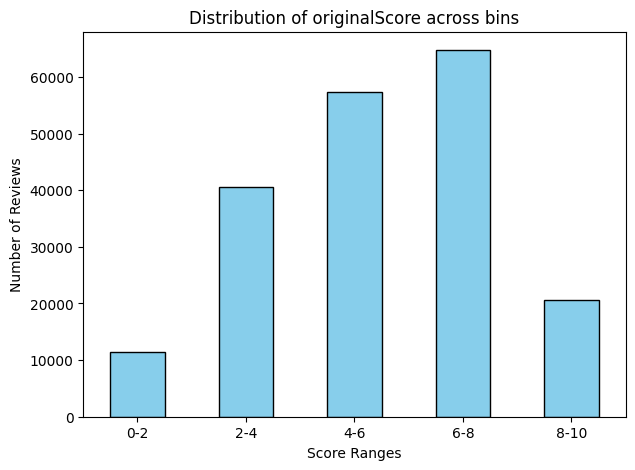

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and 'originalScore' is a column in it
# Example DataFrame (uncomment to run this as a standalone example)
# data = {'originalScore': [0, 1, 2, 2, 2.5, 3.9, 4, 5, 6, 7.5, 8, 8.1, 9, 10]}
# df = pd.DataFrame(data)

# ==========================
# Step 3: Bin originalScore
# ==========================
bin_edges = [0, 2, 4, 6, 8, 10]   # Non-overlapping bins
bin_labels = ["0-2", "2-4", "4-6", "6-8", "8-10"]

# --- CHANGE IS HERE ---
# Removed 'right=False'. Now it uses the default right=True.
df["originalScore_bin"] = pd.cut(df["originalScore"], bins=bin_edges, labels=bin_labels, include_lowest=True)

# ==========================
# Step 4: Count values in bins
# ==========================
bin_counts = df["originalScore_bin"].value_counts().sort_index()
print("\nCounts per bin:\n", bin_counts)

# ==========================
# Step 5: Plot bar chart
# ==========================
plt.figure(figsize=(7,5))
bin_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of originalScore across bins")
plt.xlabel("Score Ranges")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

**5 bin quantile**

originalScore_quantile_bin
Q1    52053
Q2    32377
Q3    35793
Q4    53882
Q5    20696
Name: count, dtype: int64


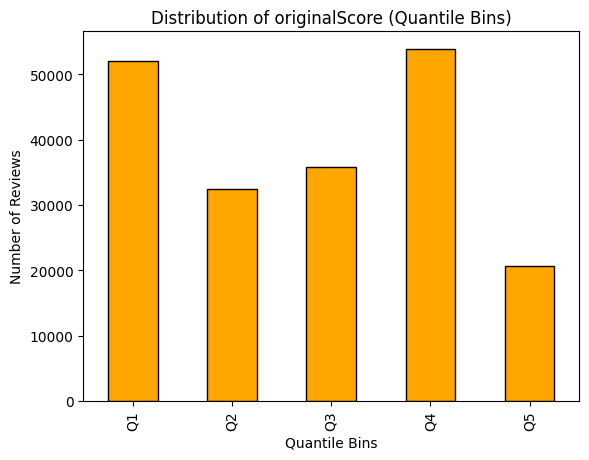

In [ ]:
df["originalScore_quantile_bin"] = pd.qcut(df["originalScore"], q=5, labels=["Q1","Q2","Q3","Q4","Q5"])

quantile_counts = df["originalScore_quantile_bin"].value_counts().sort_index()
print(quantile_counts)

quantile_counts.plot(kind="bar", color="orange", edgecolor="black")
plt.title("Distribution of originalScore (Quantile Bins)")
plt.xlabel("Quantile Bins")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
# --- How to get the ranges ---
# Group by the bins and get min/max of the *originalScore*
print("\nScore Ranges (Original Method):")
bin_ranges_original = df.groupby('originalScore_quantile_bin')['originalScore'].agg(['min', 'max'])
print(bin_ranges_original)


Score Ranges (Original Method):
                             min    max
originalScore_quantile_bin             
Q1                          0.00   4.00
Q2                          4.02   5.00
Q3                          5.01   6.25
Q4                          6.30   8.00
Q5                          8.10  10.00


/tmp/ipython-input-3739213247.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_ranges_original = df.groupby('originalScore_quantile_bin')['originalScore'].agg(['min', 'max'])


In [ ]:
# 1. Create a 'rank' column. 'method="first"' gives each row a unique rank.
df['originalScore_rank'] = df['originalScore'].rank(method='first')

# 2. Bin the RANK column. This will create perfectly equal bins.
df['equal_quantile_bin'] = pd.qcut(df['originalScore_rank'], q=5, labels=["Q1","Q2","Q3","Q4","Q5"])

# 3. Check the counts (they will be equal)
equal_counts = df['equal_quantile_bin'].value_counts().sort_index()
print("\nCounts per bin (Equal Rank Method):\n", equal_counts)

# 4. Get the score ranges for these new equal bins
print("\nScore Ranges (Equal Rank Method):")
bin_ranges_equal = df.groupby('equal_quantile_bin')['originalScore'].agg(['min', 'max'])
print(bin_ranges_equal)


Counts per bin (Equal Rank Method):
 equal_quantile_bin
Q1    38961
Q2    38960
Q3    38960
Q4    38960
Q5    38960
Name: count, dtype: int64

Score Ranges (Equal Rank Method):
                     min    max
equal_quantile_bin             
Q1                  0.00   4.00
Q2                  4.00   5.00
Q3                  5.00   6.25
Q4                  6.25   8.00
Q5                  8.00  10.00


/tmp/ipython-input-2573730747.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_ranges_equal = df.groupby('equal_quantile_bin')['originalScore'].agg(['min', 'max'])


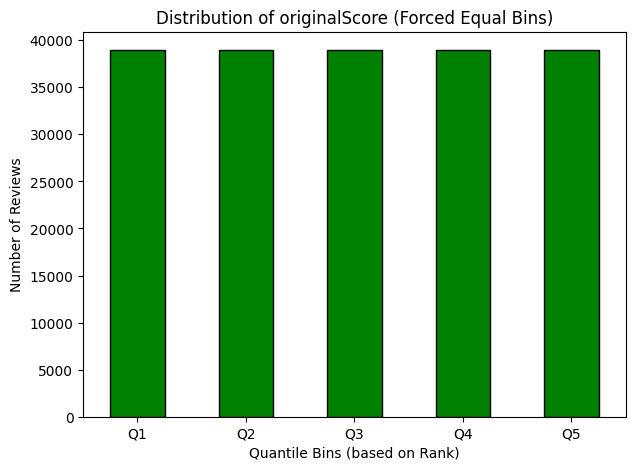

In [ ]:
import matplotlib.pyplot as plt

# ===================================================
# Step 5: Plot the bar chart for the EQUAL bins
# ===================================================

# This assumes 'equal_counts' was created in the previous step:
# equal_counts = df['equal_quantile_bin'].value_counts().sort_index()

plt.figure(figsize=(7, 5))
equal_counts.plot(kind="bar", color="green", edgecolor="black")
plt.title("Distribution of originalScore (Forced Equal Bins)")
plt.xlabel("Quantile Bins (based on Rank)")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()

originalScore_custom_bin
Very Negative    16673
Negative         38708
Neutral          69067
Positive         58302
Very Positive     4823
Name: count, dtype: int64


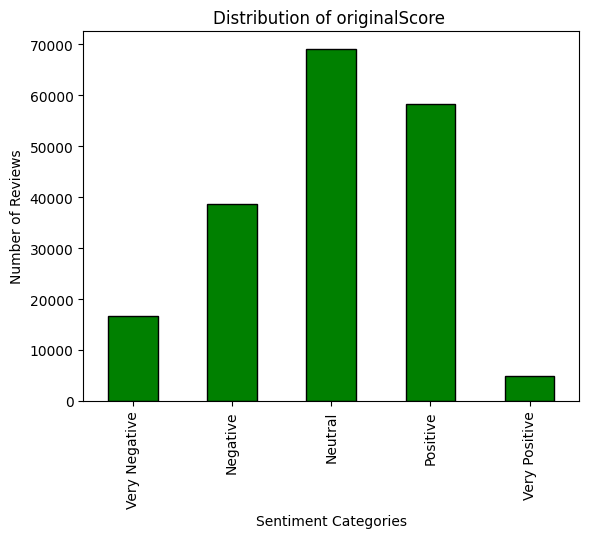

In [ ]:
custom_bins = [0, 3, 5, 7, 9, 10]
custom_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

df["originalScore_custom_bin"] = pd.cut(df["originalScore"], bins=custom_bins, labels=custom_labels, include_lowest=True, right=False)

custom_counts = df["originalScore_custom_bin"].value_counts().sort_index()
print(custom_counts)

custom_counts.plot(kind="bar", color="green", edgecolor="black")
plt.title("Distribution of originalScore ")
plt.xlabel("Sentiment Categories")
plt.ylabel("Number of Reviews")
plt.show()


originalScore_custom_bin
Very Negative    11454
Negative         43927
Neutral          69067
Positive         49912
Very Positive    13213
Name: count, dtype: int64


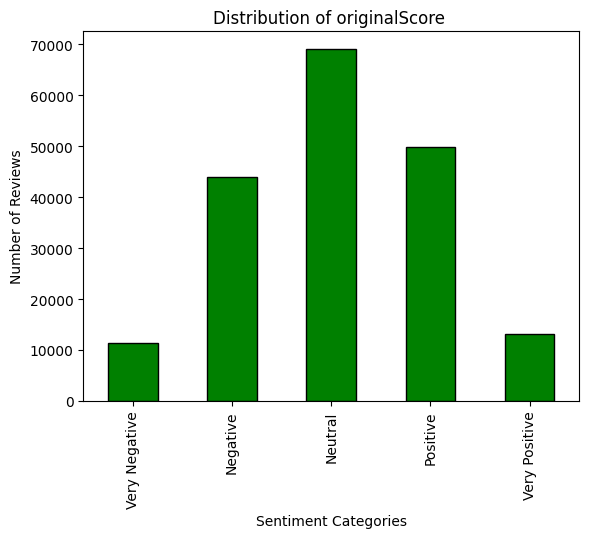

In [ ]:
custom_bins = [0, 2.5, 5, 7, 8.5, 10]
custom_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

df["originalScore_custom_bin"] = pd.cut(df["originalScore"], bins=custom_bins, labels=custom_labels, include_lowest=True, right=False)

custom_counts = df["originalScore_custom_bin"].value_counts().sort_index()
print(custom_counts)

custom_counts.plot(kind="bar", color="green", edgecolor="black")
plt.title("Distribution of originalScore ")
plt.xlabel("Sentiment Categories")
plt.ylabel("Number of Reviews")
plt.show()